# Identifying Geologic Facies Through Seismic Dataset-to-Dataset Transfer Learning using CNN

## This code consists of two parts
- Part I: Train with Parihaka Data (Traditional Learning) 
- Part II: Train with Nethderlands F3 Data with transfer learning from part I

### This code is a clean outline for how we trained our data using many different scenarios and orders of hyperparameters. Please see the attached testing results folder to see more in depth testing done with different hyperparameters. However, these notebooks will not be as clean as the one provided here. 




In [ ]:
# Check to see if we are using a high performance GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov  2 22:00:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import files

In [1]:
# import libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

import math
from scipy.signal.windows import triang
from scipy.signal import convolve2d as conv2

from tqdm.notebook import tqdm #progress bar

import cv2

import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split

from IPython.display import HTML

import cv2
import imutils

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3309568/45929032 bytes (7.2%)7340032/45929032 bytes (16.0%)11198464/45929032 bytes (24.4%)15204352/45929032 bytes (33.1%)19013632/45929032 bytes (41.4%)22855680/45929032 bytes (49.8%)26746880/45929032 bytes (58.2%)30556160/45929032 bytes (66.5%)34373632/45929032 bytes (74.8%)38166528/45929032 bytes (83.1%)42090496/45929032 bytes (91.6%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

### Data Preprocessing 
#### Loading in Dataset 1 (Parihaka)

In [2]:
data_train_parihaka = np.load('/content/drive/MyDrive/Dataset /data_train.npz',  
               allow_pickle=True, mmap_mode = 'r')['data']


label_train_parihaka = np.load('/content/drive/MyDrive/Dataset /labels_train.npz',  
               allow_pickle=True, mmap_mode = 'r')['labels']

In [3]:
print('Shape X:', data_train_parihaka.shape)
print('Shape Y:', label_train_parihaka.shape)

Shape X: (1006, 782, 590)
Shape Y: (1006, 782, 590)


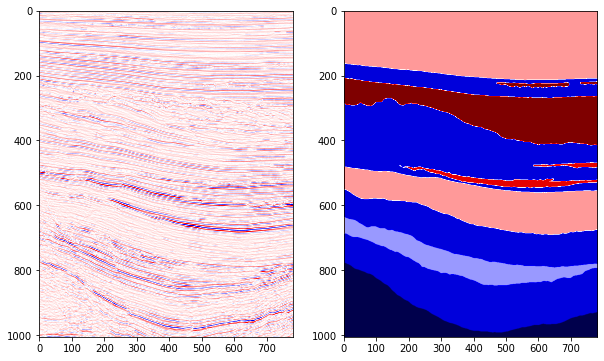

In [4]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_train_parihaka[:,:,200], cmap='seismic')
ax[1].imshow(label_train_parihaka[:,:,200], cmap='seismic')

#### Loading Dataset 2 (Netherlands F3 Block) 
##### We will use this one for transfer learning once we have trustworthy weights. 

In [5]:
data_train_netherlands = np.load('/content/drive/MyDrive/Dataset /Dataset_2/train_seismic.npy')


label_train_netherlands = np.load('/content/drive/MyDrive/Dataset /Dataset_2/train_labels.npy')

In [6]:
print('Shape X:', data_train_netherlands.shape)
print('Shape Y:', label_train_netherlands.shape)

Shape X: (401, 701, 255)
Shape Y: (401, 701, 255)


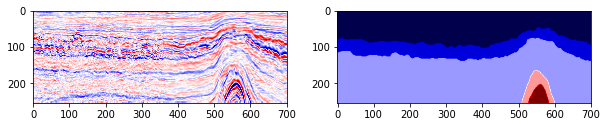

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_train_netherlands[400,:,:].T, cmap='seismic')
ax[1].imshow(label_train_netherlands[400,:,:].T, cmap='seismic')

In [8]:
data_test1_netherlands = np.load('/content/drive/MyDrive/Dataset /Dataset_2/test1_seismic.npy')


label_test1_netherlands= np.load('/content/drive/MyDrive/Dataset /Dataset_2/test1_labels.npy')

In [9]:
print('Shape X:', data_test1_netherlands.shape)
print('Shape Y:', label_test1_netherlands.shape)

Shape X: (200, 701, 255)
Shape Y: (200, 701, 255)


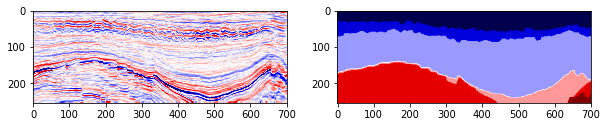

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_test1_netherlands[20,:,:].T, cmap='seismic')
ax[1].imshow(label_test1_netherlands[20,:,:].T, cmap='seismic')

## Implement Data Preprocessing 

### Gain + RMS

In [11]:
def gain(data,dt,parameters):
    nt,nx = data.shape
    dout = np.zeros(data.shape)
    L = parameters/dt+1
    L = np.floor(L/2)
    h = triang(2*L+1)
    shaped_h  = h.reshape(len(h),1)
    for k in range(nx):
        aux = data[:,k]
        e = aux**2
        shaped_e = e.reshape(len(e),1)
        rms = np.sqrt(conv2(shaped_e,shaped_h,"same"))
        epsi = 1e-10*max(rms)
        op = rms/(rms**2+epsi)
        op = op.reshape(len(op),)
        dout[:,k] = data[:,k]*op
    for k in range(nx):
        aux = dout[:,k]
        amax = np.sqrt(sum(aux**2)/nt)
        dout[:,k] = dout[:,k]/amax
    return dout

In [12]:
test_image=data_train_parihaka[:,200,:]
test_gain =gain(test_image,3e-3,0.8)

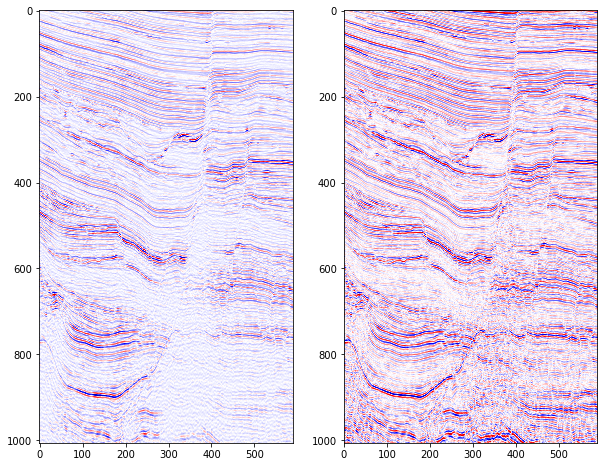

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_train_parihaka[:,200,:], cmap='seismic')
ax[1].imshow(test_gain, cmap='seismic')

In [14]:
# load in an RMS processed dataset
data_train_parihaka_pp = np.load('/content/drive/MyDrive/Dataset /data_train_processed.npz',  
               allow_pickle=True, mmap_mode = 'r')['data']

2-D Image Making

In [15]:
training_img_data = []
training_label_data = []

for i in tqdm(range(0, 580)): #reshaping the images into appropriate sizes 
  img = data_train_parihaka_pp[:, :, i] 
  label = label_train_parihaka[:, :, i]

  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (128, 128))
  label = cv2.resize(label, (128, 128))

  img = img/np.amax(img)
  img = np.clip(img, 0, 255)
  img = (img*255).astype(int)

  img = img/255.

  img = cv2.merge([img,img,img])

  training_img_data.append(img) 
  training_label_data.append(label)
  

  0%|          | 0/580 [00:00<?, ?it/s]

In [16]:
print('Before Data Reshape', np.array(data_train_parihaka_pp).shape)
print('After Data Reshape', np.array(training_img_data).shape)

print('Before Target Reshape', np.array(label_train_parihaka).shape)
print('After Target Reshape', np.array(training_label_data).shape)

Before Data Reshape (1006, 782, 590)
After Data Reshape (580, 128, 128, 3)
Before Target Reshape (1006, 782, 590)
After Target Reshape (580, 128, 128)


In [17]:
training_img_data = np.asarray(training_img_data)

training_label_data = np.asarray(training_label_data)

print(training_label_data.shape)

(580, 128, 128)


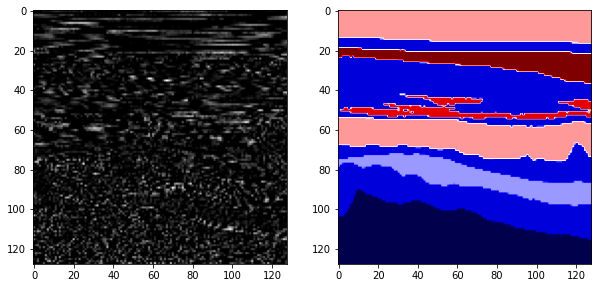

In [18]:

fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(training_img_data[0,:,:,:], cmap='seismic')
ax[1].imshow(training_label_data[0,:,:], cmap='seismic')

In [19]:
# Augmentation
datagen = ImageDataGenerator(horizontal_flip = True, shear_range = 0.2, zoom_range = 0.2)
datagen_test = ImageDataGenerator(horizontal_flip = True)

datagen.fit(training_img_data)

## Processing F3 Data

In [20]:
training_img_data_f3 = []
training_label_data_f3 = []

for i in tqdm(range(0, 401)): #reshaping the images into appropriate sizes 
  img = data_train_netherlands[i, :, :].T
  label = label_train_netherlands[i, :, :].T

  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (128, 128))
  label = cv2.resize(label, (128, 128))

  img = img/np.amax(img)
  img = np.clip(img, 0, 255)
  img = (img*255).astype(int)

  img = img/255.

  img = cv2.merge([img,img,img])

  training_img_data_f3.append(img) 
  training_label_data_f3.append(label)

  0%|          | 0/401 [00:00<?, ?it/s]

In [21]:
test1_img_data_f3 = []
test1_label_data_f3 = []

for i in tqdm(range(0, 200)): #reshaping the images into appropriate sizes 
  img = data_test1_netherlands[i, :, :].T 
  label = label_test1_netherlands[i, :, :].T

  img = np.expand_dims(img, axis=2).astype('float32')
  label = np.expand_dims(label, axis=2).astype('float32')

  img = cv2.resize(img, (128, 128))
  label = cv2.resize(label, (128, 128))

  img = img/np.amax(img)
  img = np.clip(img, 0, 255)
  img = (img*255).astype(int)

  img = img/255.

  img = cv2.merge([img,img,img])

  test1_img_data_f3.append(img) 
  test1_label_data_f3.append(label)

  0%|          | 0/200 [00:00<?, ?it/s]

In [22]:
# Need to convert data into arrays
training_img_data_f3 = np.asarray(training_img_data_f3)

training_label_data_f3 = np.asarray(training_label_data_f3)

test1_img_data_f3 = np.asarray(test1_img_data_f3)

test1_label_data_f3 = np.asarray(test1_label_data_f3)


print('Converted F3 Dims:', training_img_data_f3.shape)
print('Converted F3 Dims (Test):', test1_img_data_f3.shape)

Converted F3 Dims: (401, 128, 128, 3)
Converted F3 Dims (Test): (200, 128, 128, 3)


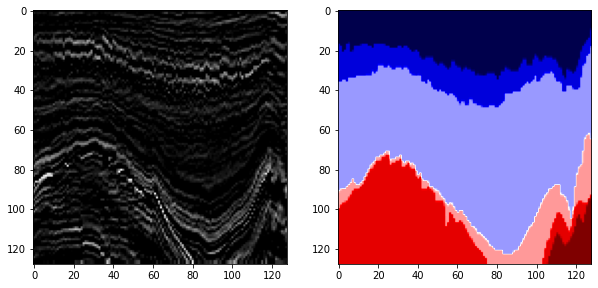

In [23]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(test1_img_data_f3[20,:,:,:], cmap='seismic')
ax[1].imshow(test1_label_data_f3[100,:,:], cmap='seismic')

In [24]:
# Augmentation for F3 Data
datagen_f3 = ImageDataGenerator(horizontal_flip = True, shear_range = 0.2, zoom_range = 0.6)

datagen_f3.fit(test1_img_data_f3)

Developing the Model Using Keras API

Attempt #1: U-Net without Augmentation

In [ ]:
ACTIVATION = 'relu'
ACTIVATION_OUT = 'softmax'
initializer = 'he_normal'
input_size = np.array(training_img_data).shape[1:]
N_classes = 7


In [ ]:
def UNet1(input_size, N_CLASSES, activation_name, initialization_name, DropoutRatio = 0.5): 
  # Encoder

  # Block encoder 1
  inputs = Input(shape=input_size)
  conv_enc_1 = Conv2D(64, 3, activation = ACTIVATION, padding='same', kernel_initializer=initializer)(inputs)
  conv_enc_1 = BatchNormalization()(conv_enc_1)
  conv_enc_1 = Conv2D(64, 3, activation = ACTIVATION, padding='same', kernel_initializer=initializer)(conv_enc_1)
  conv_enc_1 = BatchNormalization()(conv_enc_1)
  conv_enc_1 = Activation(ACTIVATION)(conv_enc_1)

  # Block encoder 2
  max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
  max_pool_enc_2 = Dropout(DropoutRatio/2)(max_pool_enc_2)
  conv_enc_2 = Conv2D(128, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
  conv_enc_2 = BatchNormalization()(conv_enc_2)
  conv_enc_2 = Conv2D(128, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_enc_2)
  conv_enc_2 = BatchNormalization()(conv_enc_2)
  conv_enc_2 = Activation(ACTIVATION)(conv_enc_2)

  # Block  encoder 3
  max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
  max_pool_enc_3 = Dropout(DropoutRatio)(max_pool_enc_3)
  conv_enc_3 = Conv2D(256, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
  conv_enc_3 = BatchNormalization()(conv_enc_3)
  conv_enc_3 = Conv2D(256, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_enc_3)
  conv_enc_3 = BatchNormalization()(conv_enc_3)
  conv_enc_3 = Activation(ACTIVATION)(conv_enc_3)

  # Block  encoder 4
  max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
  max_pool_enc_4 = Dropout(DropoutRatio)(max_pool_enc_4)
  conv_enc_4 = Conv2D(512, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
  conv_enc_4 = BatchNormalization()(conv_enc_4)
  conv_enc_4 = Conv2D(512, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_enc_4)
  conv_enc_4 = BatchNormalization()(conv_enc_4)
  conv_enc_4 = Activation(ACTIVATION)(conv_enc_4)
  #

  # ----------- #
  maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
  maxpool = Dropout(DropoutRatio)(maxpool)
  conv = Conv2D(1024, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(maxpool)
  conv = BatchNormalization()(conv)
  conv = Conv2D(1024, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv)
  conv = BatchNormalization()(conv)
  conv = Activation(ACTIVATION)(conv)

  # ----------- #

  # Decoder

  # Block decoder 1
  up_dec_1 = Conv2D(512, 2, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
  merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
  merge_dec_1 = Dropout(DropoutRatio)(merge_dec_1)
  conv_dec_1 = Conv2D(512, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(merge_dec_1)
  conv_dec_1 = BatchNormalization()(conv_dec_1)
  conv_dec_1 = Conv2D(512, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_dec_1)
  conv_dec_1 = BatchNormalization()(conv_dec_1)
  conv_dec_1 = Activation(ACTIVATION)(conv_dec_1)

  # Block decoder 2
  up_dec_2 = Conv2D(256, 2, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
  merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
  merge_dec_2 = Dropout(DropoutRatio)(merge_dec_2)
  conv_dec_2 = Conv2D(256, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(merge_dec_2)
  conv_dec_2 = BatchNormalization()(conv_dec_2)
  conv_dec_2 = Conv2D(256, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_dec_2)
  conv_dec_2 = BatchNormalization()(conv_dec_2)
  conv_dec_2 = Activation(ACTIVATION)(conv_dec_2)

  # Block decoder 3
  up_dec_3 = Conv2D(128, 2, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
  merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
  merge_dec_3 = Dropout(DropoutRatio)(merge_dec_3)
  conv_dec_3 = Conv2D(128, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(merge_dec_3)
  conv_dec_3 = BatchNormalization()(conv_dec_3)
  conv_dec_3 = Conv2D(128, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_dec_3)
  conv_dec_3 = BatchNormalization()(conv_dec_3)
  conv_dec_3 = Activation(ACTIVATION)(conv_dec_3)

  # Block decoder 4
  up_dec_4 = Conv2D(64, 2, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
  merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
  merge_dec_4 = Dropout(DropoutRatio)(merge_dec_4)
  conv_dec_4 = Conv2D(64, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(merge_dec_4)
  conv_dec_4 = BatchNormalization()(conv_dec_4)
  conv_dec_4 = Conv2D(64, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_dec_4)
  conv_dec_4 = BatchNormalization()(conv_dec_4)
  conv_dec_4 = Activation(ACTIVATION)(conv_dec_4)

  #last = tf.keras.layers.Conv2DTranspose(1, 3, strides=1, padding='same')(conv_dec_4) 
  output = Conv2D(N_CLASSES, 1, activation = ACTIVATION_OUT)(conv_dec_4)

  # pred_mask = tf.argmax(output, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
  # pred_mask = tf.expand_dims(pred_mask, axis=-1)
  # pred_mask = tf.cast(pred_mask, tf.int64)
   # Lets create the model. Here we initialize the Keras model instance. We use this later to train/test. 
  
  model = tf.keras.Model(inputs = inputs, outputs = output)

  return inputs, output

#### Create the Model

In [ ]:
inputs, output = UNet1(input_size, N_CLASSES = N_classes, activation_name = ACTIVATION, initialization_name= initializer)

pari_model_unet = tf.keras.Model(inputs = inputs, outputs = output)

print(pari_model_unet.summary())

#### Compile the Model

Add in our optimizers. We will start with ADAM and sparse categorical cross entropy.

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=7))
    y_pred_f = K.flatten(y_pred)
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + 1) / (K.sum(y_true_f**2) + K.sum(y_pred_f**2) + 1)

In [ ]:
model_path="{}.h5".format('fixed_model_unet_1') #hdf5
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only = False)

In [ ]:
pari_model_unet.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy' , dice_coef])

In [ ]:
# Checks shapes of the data
print(training_img_data.shape)
print(training_label_data.shape)

## Split the train and validation data
#### Our test data didn't come with labels so we needed to take the validation data from our training distribution and seperate it. This ultimately shouldn't matter since most of the dataset in the 3-D seismic cube is relatively similar. 

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(training_img_data, training_label_data,test_size=0.2, shuffle= True)

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, update_freq='batch')

#model_history = pari_model_unet.fit(training_img_data, training_label_data, validation_split=0.2, epochs=50, callbacks=[tensorboard_callback]) # fit without augmentation
model_history = pari_model_unet.fit(datagen.flow(x_train, y_train), validation_data=(x_valid, y_valid), epochs=100, callbacks=[tensorboard_callback, checkpoint]) # fit with augmentation

In [ ]:
# Function to plot our metrics 
def PlotHistory(_model, feature, start_epoch = 0, path_file = None):
    val = "val_" + feature
    
    plt.xlabel('Epoch Number' + str(start_epoch))
    plt.ylabel(feature)
    plt.plot(_model.history[feature][start_epoch:])
    plt.plot(_model.history[val][start_epoch:])
    plt.title(val)
    plt.legend(["train_"+feature, val])   

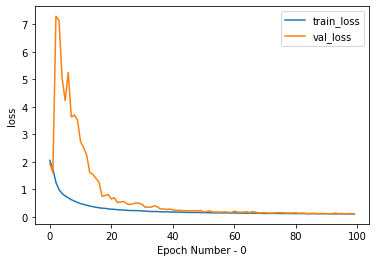

In [ ]:
PlotHistory(model_history, 'loss')

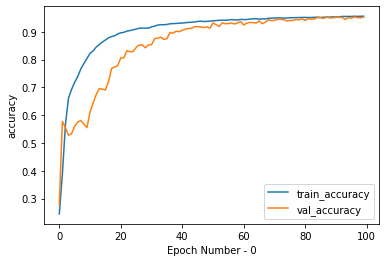

In [ ]:
PlotHistory(model_history, 'accuracy')

### Predict off of the training data

In [ ]:
pred_test = pari_model_unet.predict(training_img_data)
print(pred_test.shape)
pred_mask = tf.argmax(pred_test, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask = tf.expand_dims(pred_mask, axis=-1)
print(pred_mask.shape)

(580, 128, 128, 7)
(580, 128, 128, 1)


[[[[1.15084723e-02 1.21051390e-02 1.16723767e-02 ... 9.19940114e-01
    1.89454630e-02 1.36038223e-02]
   [7.53825181e-04 7.37932278e-04 4.11382469e-04 ... 9.94191825e-01
    2.23974185e-03 7.87498662e-04]
   [2.16301443e-04 2.05827222e-04 7.90479389e-05 ... 9.98491883e-01
    6.39243808e-04 1.41818367e-04]
   ...
   [4.70527477e-04 4.12964524e-04 2.39005065e-04 ... 9.97348189e-01
    7.93736952e-04 2.62505957e-04]
   [7.19882082e-04 1.07795524e-03 6.26620313e-04 ... 9.95152712e-01
    1.09606620e-03 4.80713847e-04]
   [9.19613894e-03 1.54854786e-02 6.46004779e-03 ... 9.44290757e-01
    6.90537365e-03 6.24601915e-03]]

  [[2.10788287e-03 1.67507923e-03 1.18211471e-03 ... 9.87314820e-01
    3.31741618e-03 1.67330389e-03]
   [2.05005650e-04 1.52691107e-04 3.95625757e-05 ... 9.98610139e-01
    4.96462279e-04 1.18410106e-04]
   [4.55287591e-05 4.21661280e-05 5.27362863e-06 ... 9.99647379e-01
    1.49397834e-04 2.22855833e-05]
   ...
   [9.04497720e-05 5.25342621e-05 1.22733081e-05 ... 9.99

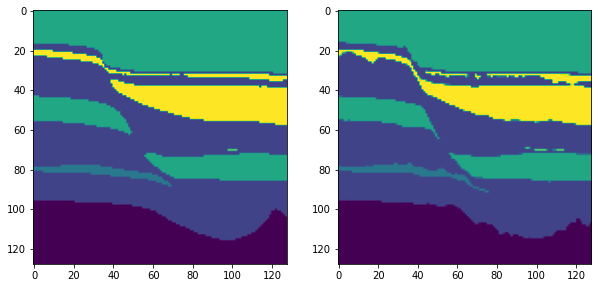

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(pred_mask[400, :, :, 0])
ax[1].imshow(training_label_data[400, :, :])

print(pred_test)

Importing the Test Data

In [ ]:
data_test_parihaka_1 = np.load('/content/drive/MyDrive/Dataset /data_test_1.npz')


data_test_parihaka_2 = np.load('/content/drive/MyDrive/Dataset /data_test_2.npz')

data_test_parihaka_1 = data_test_parihaka_1['data']
data_test_parihaka_2 = data_test_parihaka_2['data']

(1006, 782, 251)


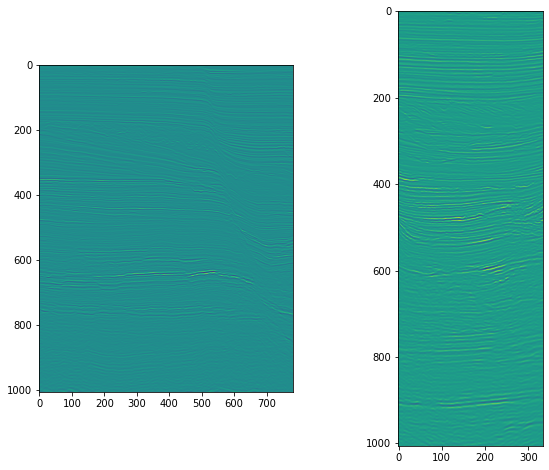

In [ ]:
# Plot our test data examples
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(data_test_parihaka_1[:,:,1])
ax[1].imshow(data_test_parihaka_2[:,:,1])

print(data_test_parihaka_1.shape)

In [ ]:
testing_img_data_1 = []
testing_img_data_2 = []

def preprocess_input(data_in, data_out, axis):
  for i in range(0, axis):
    img = data_in[:, :, i]
    img = np.expand_dims(img, axis=2).astype('float32')
    

    img = cv2.resize(img, (128, 128))

    img = img/np.amax(img)
    img = np.clip(img, 0, 255)
    img = (img*255).astype(int)
    img = cv2.merge([img,img,img])

    data_out.append(img)

  return data_out

testing_img_data_1 = preprocess_input(data_test_parihaka_1, testing_img_data_1, 251)
testing_img_data_2 = preprocess_input(data_test_parihaka_2, testing_img_data_2, 251)

In [ ]:
testing_img_data_1 = np.asarray(testing_img_data_1)
testing_img_data_2 = np.asarray(testing_img_data_2)

In [ ]:
testing_img_data_1.shape

(251, 128, 128, 3)

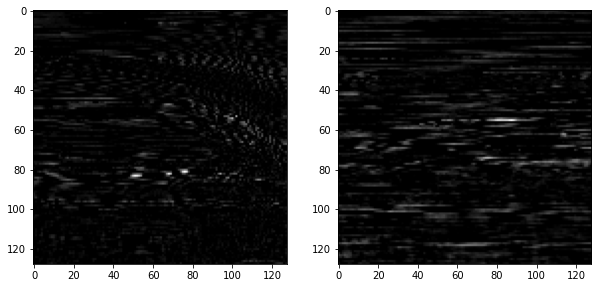

In [ ]:
# Plot our test data examples
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(testing_img_data_1[100,:,:,:])
ax[1].imshow(testing_img_data_2[100,:,:,:])

In [ ]:
pred_test_data_pari = pari_model_unet.predict(testing_img_data_1)

print(pred_test_data_pari.shape)
pred_mask_test_pari = tf.argmax(pred_test_data_pari, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask_test_pari = tf.expand_dims(pred_mask_test_pari, axis=-1)
print(pred_mask_test_pari.shape)


(251, 128, 128, 7)
(580, 128, 128, 1)


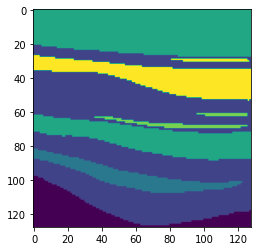

In [ ]:
plt.imshow(pred_mask_test_pari[200, :, :, 0])

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(pred_mask_test_pari[4, :, :, 0])
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Predicted Facies')
fig.suptitle('Prediction with Test (Parihaka)')

# Transfer Learning with U-Net 

In [ ]:
base_model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset /fixed_model_unet_1.h5')

In [ ]:
# for layer in base_model.layers:
#   layer.trainable = False

for layer in base_model.layers[:69]:
   layer.trainable = False
for layer in base_model.layers[69:]:
   layer.trainable = True

In [ ]:
N_CLASSES_F3 = 7
transfer_out = base_model.output
transfer_out = tf.keras.layers.Conv2D(N_CLASSES_F3, 1, activation = 'softmax', name='transfer_notune')(transfer_out)

In [ ]:
transfer_model_unet = tf.keras.Model(inputs=base_model.input, outputs=transfer_out)

In [ ]:
#for layer in base_model.layers:
  #layer.trainable = False

In [ ]:
model_path_transfer = "{}.h5".format('fixed_model_unet_1_transfer') #hdf5
checkpoint = ModelCheckpoint(model_path_transfer, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only = False)

In [ ]:
transfer_model_unet.compile(optimizer=Adam(learning_rate=0.001), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy', dice_coef])

In [ ]:
x_split, x_test_f3, y_split, y_test_f3 = train_test_split(training_img_data_f3, training_label_data_f3,test_size=0.98, shuffle= False)
x_train_f3, x_val_f3, y_train_f3, y_val_f3 = train_test_split(x_split, y_split, test_size=0.2, shuffle= False)

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, update_freq='batch')

# transfer_model_history = transfer_model_unet.fit(x_train_f3, y_train_f3, validation_data=(x_val_f3, y_val_f3), epochs=20 callbacks=[tensorboard_callback, checkpoint]) 
transfer_model_history = transfer_model_unet.fit(datagen_f3.flow(x_train_f3, y_train_f3), validation_data=(x_val_f3, y_val_f3), epochs=400, callbacks=[tensorboard_callback])

Epoch 1/400
1/1 [==============================] - 9s 9s/step - loss: 1.7920 - accuracy: 0.1536 - val_loss: 1.7934 - val_accuracy: 0.1970
Epoch 2/400
1/1 [==============================] - 6s 6s/step - loss: 1.7857 - accuracy: 0.1578 - val_loss: 1.7904 - val_accuracy: 0.2017
Epoch 3/400
1/1 [==============================] - 6s 6s/step - loss: 1.7817 - accuracy: 0.1700 - val_loss: 1.7875 - val_accuracy: 0.2068
Epoch 4/400
1/1 [==============================] - 6s 6s/step - loss: 1.7822 - accuracy: 0.1759 - val_loss: 1.7845 - val_accuracy: 0.2661
Epoch 5/400
1/1 [==============================] - 5s 5s/step - loss: 1.7802 - accuracy: 0.2586 - val_loss: 1.7815 - val_accuracy: 0.3409
Epoch 6/400
1/1 [==============================] - 6s 6s/step - loss: 1.7745 - accuracy: 0.2968 - val_loss: 1.7786 - val_accuracy: 0.3603
Epoch 7/400
1/1 [==============================] - 6s 6s/step - loss: 1.7724 - accuracy: 0.3125 - val_loss: 1.7756 - val_accuracy: 0.3705
Epoch 8/400
1/1 [=================

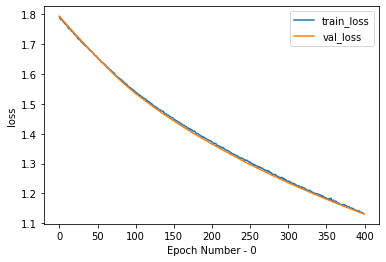

In [ ]:
PlotHistory(transfer_model_history, 'loss')

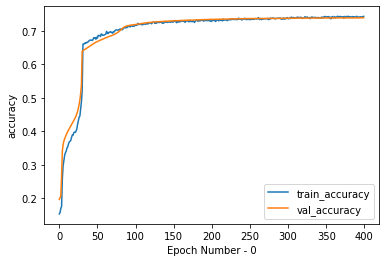

In [ ]:
PlotHistory(transfer_model_history, 'loss')

In [ ]:
pred_test_f3 = transfer_model_unet.predict(x_train_f3)
print(pred_test_f3.shape)
pred_mask_f3 = tf.argmax(pred_test_f3, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask_f3 = tf.expand_dims(pred_mask_f3, axis=-1)
print(pred_mask_f3.shape)

(32, 128, 128, 7)
(32, 128, 128, 1)


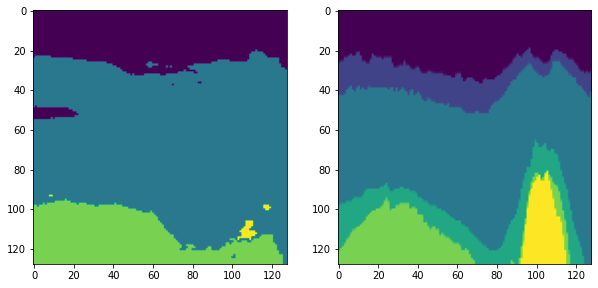

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(pred_mask_f3[4, :, :, 0])
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Predicted Facies')
ax[1].imshow(y_train_f3[4, :, :])
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('Predicted Facies')
fig.suptitle('Transfer Learning Prediction with Training (Netherlands F3)')

# Now knowing the information from the Parihaka is overbearing in the transfer learning, we need to fine tune with transfer learning

In [102]:
# upload the base model

base_model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset /fixed_model_unet_1.h5')

In [103]:
# check the numbers for each layer to figure out what we need to freeze 

for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 conv2d_1
4 batch_normalization_1
5 activation
6 max_pooling2d
7 dropout
8 conv2d_2
9 batch_normalization_2
10 conv2d_3
11 batch_normalization_3
12 activation_1
13 max_pooling2d_1
14 dropout_1
15 conv2d_4
16 batch_normalization_4
17 conv2d_5
18 batch_normalization_5
19 activation_2
20 max_pooling2d_2
21 dropout_2
22 conv2d_6
23 batch_normalization_6
24 conv2d_7
25 batch_normalization_7
26 activation_3
27 max_pooling2d_3
28 dropout_3
29 conv2d_8
30 batch_normalization_8
31 conv2d_9
32 batch_normalization_9
33 activation_4
34 up_sampling2d
35 conv2d_10
36 concatenate
37 dropout_4
38 conv2d_11
39 batch_normalization_10
40 conv2d_12
41 batch_normalization_11
42 activation_5
43 up_sampling2d_1
44 conv2d_13
45 concatenate_1
46 dropout_5
47 conv2d_14
48 batch_normalization_12
49 conv2d_15
50 batch_normalization_13
51 activation_6
52 up_sampling2d_2
53 conv2d_16
54 concatenate_2
55 dropout_6
56 conv2d_17
57 batch_normalization_14
58 conv2d_18
59 batch_

In [104]:
# Options to freeze different layers in the baseline model

for layer in base_model.layers[:64]:
   layer.trainable = False
for layer in base_model.layers[64:]:
   layer.trainable = True

# base_model.trainable = False

# leave batch normalization layers retrainable to prevent potential overfitting
for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [105]:
# This cell represents some of the potential layers that were to be added after the baseline implementation
# We have tried out different combinations of added layers to get the best result

N_CLASSES_F3 = 7
transfer_out = base_model.output
#transfer_out = Dense(1024, activation='relu')(base_model.output)
#transfer_out = Dropout(0.7, name='drop_transfer1')(transfer_out)
transfer_out = Dense(512, activation='relu')(transfer_out)
transfer_out = Dropout(0.3, name='drop_transfer2')(transfer_out)
transfer_out = Dense(256, activation='relu')(transfer_out)
transfer_out = Dropout(0.6, name='drop_transfer3')(transfer_out)
transfer_out = tf.keras.layers.Conv2D(N_CLASSES_F3, 1, activation = 'softmax', name='transfer')(transfer_out)

In [106]:
transfer_model_unet = tf.keras.Model(inputs=base_model.input, outputs=transfer_out)

In [107]:
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=7))
    y_pred_f = K.flatten(y_pred)
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def PlotHistory(_model, feature, start_epoch = 0, path_file = None):
    val = "val_" + feature
    
    plt.xlabel('Epoch Number - ' + str(start_epoch))
    plt.ylabel(feature)
    plt.plot(_model.history[feature][start_epoch:])
    plt.plot(_model.history[val][start_epoch:])
    plt.title(val)
    plt.legend(["train_"+feature, val])   

In [108]:
# Learning Rate Decay, Compile, and Training/Val/Test splits
# I had this unique configuration for the val/test split because I wanted them to come from the same distribution since I had labels with my test data this time in contrast to Parihaka

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True)
#lr_schedule = 0.001
transfer_model_unet.compile(optimizer=Adam(learning_rate=lr_schedule), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy', dice_coef])

x_train_f3, x_test_f3_throw, y_train_f3, y_test_f3_throw = train_test_split(training_img_data_f3, training_label_data_f3,test_size=0.95, shuffle= True) #take out of the bunch of the data

x_val_f3, x_test_f3, y_val_f3, y_test_f3 = train_test_split(test1_img_data_f3, test1_label_data_f3,test_size=0.95, shuffle= True) #take out of the bunch of the data

Text(0.5, 1.0, 'True Facies (Labels)')

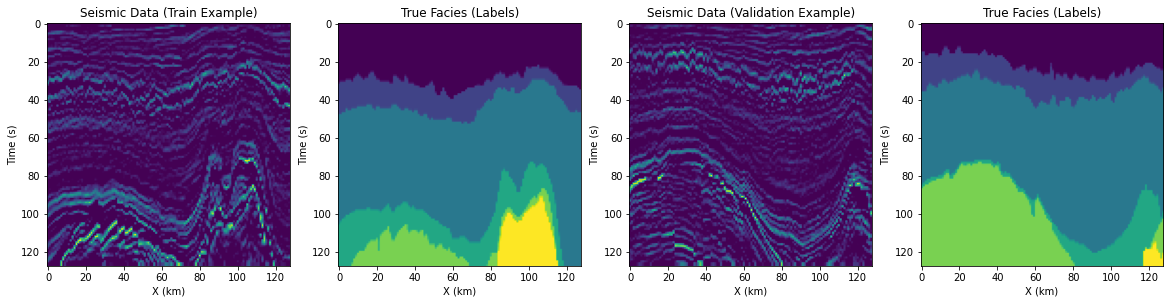

In [109]:
fig, ax = plt.subplots(1,4, figsize=(20,20))

ax[0].imshow(x_train_f3[0, :, :, 0])
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Seismic Data (Train Example)')
ax[1].imshow(y_train_f3[0, :, :])
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('True Facies (Labels)')
ax[2].imshow(x_val_f3[0, :, :, 0])
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Time (s)')
ax[2].set_title('Seismic Data (Validation Example)')
ax[3].imshow(y_val_f3[0, :, :])
ax[3].set_xlabel('X (km)')
ax[3].set_ylabel('Time (s)')
ax[3].set_title('True Facies (Labels)')

In [110]:
x_val_f3.shape
x_train_f3.shape

(20, 128, 128, 3)

In [111]:
# Implementing Early Stop and Checkpoint

model_path_transfer = "{}.h5".format('fixed_model_unet_1_transfer_tuned_1') #hdf5
checkpoint = ModelCheckpoint(model_path_transfer, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = False)
early_stop = EarlyStopping(monitor="val_dice_coef",mode="max",patience=300)

In [112]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, update_freq='batch')

transfer_model_history = transfer_model_unet.fit(x_train_f3, y_train_f3, validation_data=(x_val_f3, y_val_f3), epochs=500, callbacks=[tensorboard_callback, early_stop])
#transfer_model_history = transfer_model_unet.fit(datagen_f3.flow(x_train_f3, y_train_f3), validation_data=(x_val_f3, y_val_f3), epochs=100, callbacks=[tensorboard_callback, early_stop])

Epoch 1/500
1/1 [==============================] - 7s 7s/step - loss: 1.9661 - accuracy: 0.1169 - dice_coef: 0.1406 - val_loss: 1.5199 - val_accuracy: 0.3716 - val_dice_coef: 0.2648
Epoch 2/500
1/1 [==============================] - 4s 4s/step - loss: 1.4234 - accuracy: 0.5016 - dice_coef: 0.2796 - val_loss: 1.6996 - val_accuracy: 0.5231 - val_dice_coef: 0.4261
Epoch 3/500
1/1 [==============================] - 4s 4s/step - loss: 1.2704 - accuracy: 0.5363 - dice_coef: 0.4628 - val_loss: 1.6840 - val_accuracy: 0.4774 - val_dice_coef: 0.3958
Epoch 4/500
1/1 [==============================] - 4s 4s/step - loss: 1.2075 - accuracy: 0.6005 - dice_coef: 0.4790 - val_loss: 1.3810 - val_accuracy: 0.5045 - val_dice_coef: 0.3975
Epoch 5/500
1/1 [==============================] - 4s 4s/step - loss: 1.0708 - accuracy: 0.6042 - dice_coef: 0.4549 - val_loss: 1.2551 - val_accuracy: 0.5726 - val_dice_coef: 0.3921
Epoch 6/500
1/1 [==============================] - 4s 4s/step - loss: 1.0119 - accuracy: 0

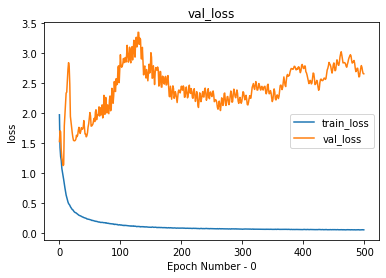

In [113]:
PlotHistory(transfer_model_history, 'loss')

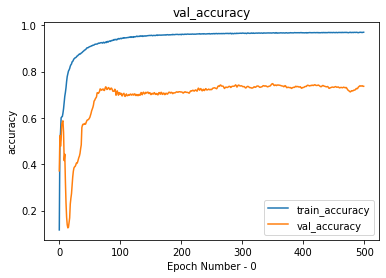

In [114]:
PlotHistory(transfer_model_history, 'accuracy')

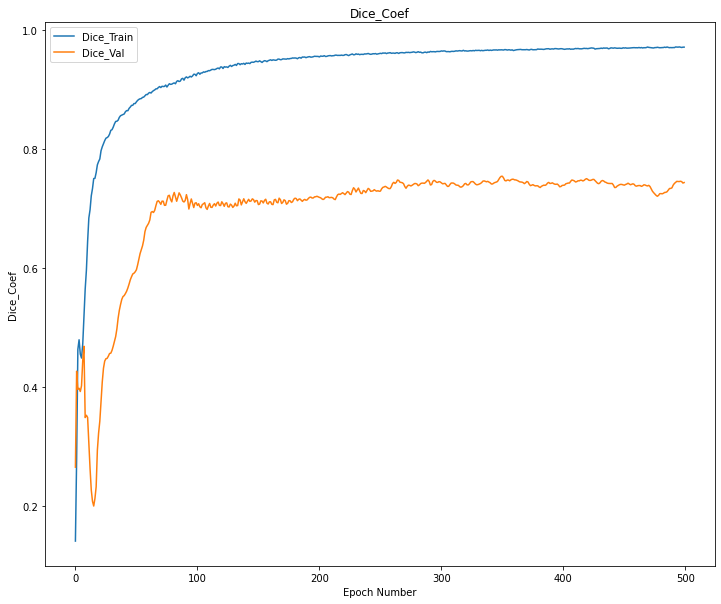

In [115]:
plt.figure(figsize=(12,10))
plt.xlabel('Epoch Number')
plt.ylabel('Dice_Coef')
plt.plot(transfer_model_history.history['dice_coef'])
plt.plot(transfer_model_history.history['val_dice_coef'])
plt.title('Dice_Coef')
plt.legend(["Dice_Train", "Dice_Val"])   
plt.show()

In [116]:
pred_train_f3 = transfer_model_unet.predict(x_train_f3)
print(pred_train_f3.shape)
pred_mask_f3 = tf.argmax(pred_train_f3, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask_f3 = tf.expand_dims(pred_mask_f3, axis=-1)
print(pred_mask_f3.shape)

(20, 128, 128, 7)
(20, 128, 128, 1)


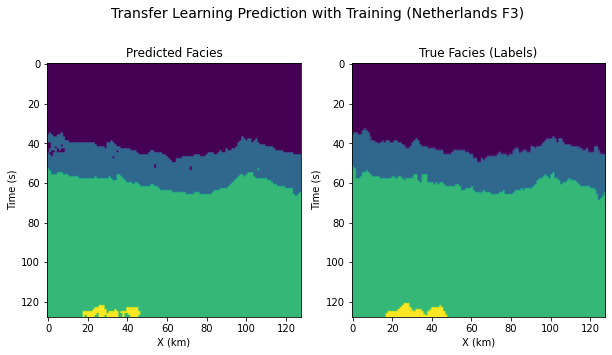

In [117]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(pred_mask_f3[18, :, :, 0])
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Time (s)')
ax[0].set_title('Predicted Facies')
ax[1].imshow(y_train_f3[18, :, :])
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Time (s)')
ax[1].set_title('True Facies (Labels)')
fig.suptitle('Transfer Learning Prediction with Training (Netherlands F3)', fontsize=14, y=0.82)
plt.show()

In [118]:
pred_test_f3 = transfer_model_unet.predict(x_test_f3)
print(pred_test_f3.shape)
pred_mask_f3_test = tf.argmax(pred_test_f3, axis=-1)
  # # pred_mask becomes [IMG_SIZE, IMG_SIZE]
  # # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
pred_mask_f3_test = tf.expand_dims(pred_mask_f3_test, axis=-1)
print(pred_mask_f3_test.shape)

(190, 128, 128, 7)
(190, 128, 128, 1)


In [119]:
transfer_model_unet.evaluate(x=x_test_f3, y=y_test_f3, callbacks=[tensorboard_callback])

6/6 [==============================] - 1s 134ms/step - loss: 2.1867 - accuracy: 0.7732 - dice_coef: 0.7805


[2.1866860389709473, 0.7731997966766357, 0.7804562449455261]

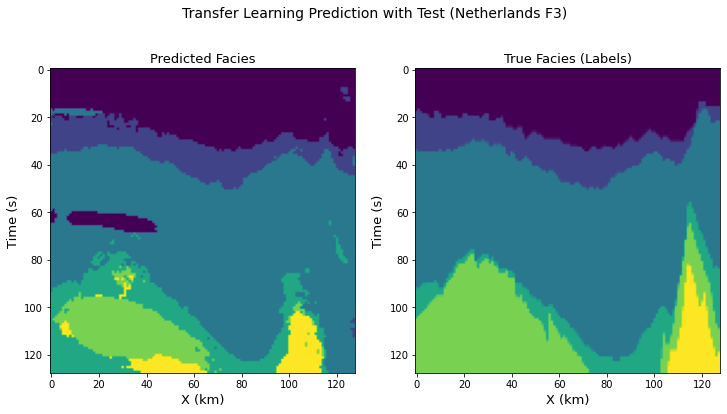

In [120]:
fig, ax = plt.subplots(1,2, figsize=(12,12))

ax[0].imshow(pred_mask_f3_test[15, :, :, 0])
ax[0].set_xlabel('X (km)', fontsize=13)
ax[0].set_ylabel('Time (s)', fontsize=13)
ax[0].set_title('Predicted Facies', fontsize=13)
ax[1].imshow(y_test_f3[15, :, :])
ax[1].set_xlabel('X (km)', fontsize=13)
ax[1].set_ylabel('Time (s)', fontsize=13)
ax[1].set_title('True Facies (Labels)', fontsize=13)
fig.suptitle('Transfer Learning Prediction with Test (Netherlands F3)', fontsize=14, y=0.75)
plt.show()

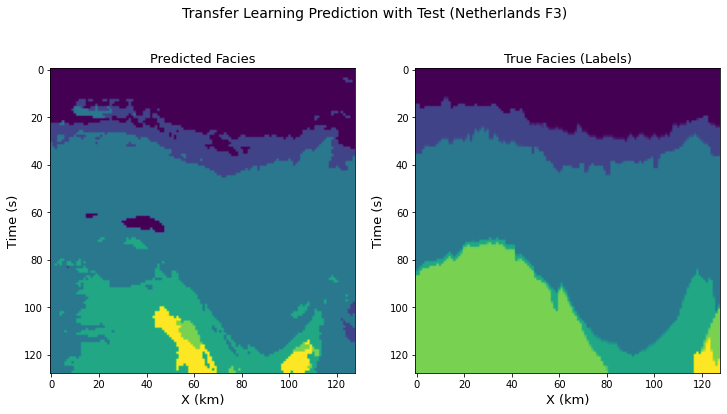

In [121]:
fig, ax = plt.subplots(1,2, figsize=(12,12))

ax[0].imshow(pred_mask_f3_test[5, :, :, 0])
ax[0].set_xlabel('X (km)', fontsize=13)
ax[0].set_ylabel('Time (s)', fontsize=13)
ax[0].set_title('Predicted Facies', fontsize=13)
ax[1].imshow(y_test_f3[5, :, :])
ax[1].set_xlabel('X (km)', fontsize=13)
ax[1].set_ylabel('Time (s)', fontsize=13)
ax[1].set_title('True Facies (Labels)', fontsize=13)
fig.suptitle('Transfer Learning Prediction with Test (Netherlands F3)', fontsize=14, y=0.75)
plt.show()

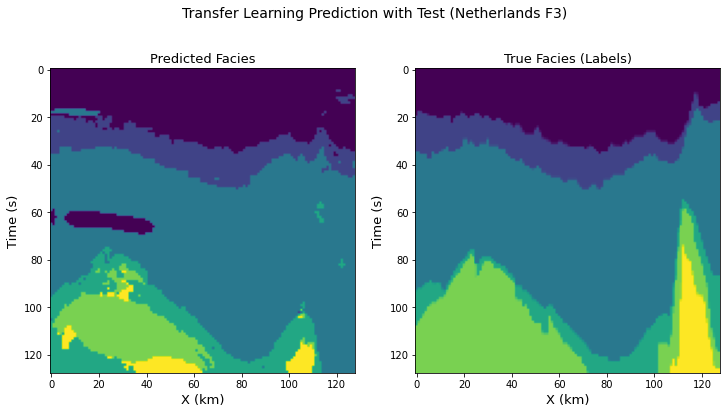

In [122]:
fig, ax = plt.subplots(1,2, figsize=(12,12))

ax[0].imshow(pred_mask_f3_test[19, :, :, 0])
ax[0].set_xlabel('X (km)', fontsize=13)
ax[0].set_ylabel('Time (s)', fontsize=13)
ax[0].set_title('Predicted Facies', fontsize=13)
ax[1].imshow(y_test_f3[19, :, :])
ax[1].set_xlabel('X (km)', fontsize=13)
ax[1].set_ylabel('Time (s)', fontsize=13)
ax[1].set_title('True Facies (Labels)', fontsize=13)
fig.suptitle('Transfer Learning Prediction with Test (Netherlands F3)', fontsize=14, y=0.75)
plt.show()

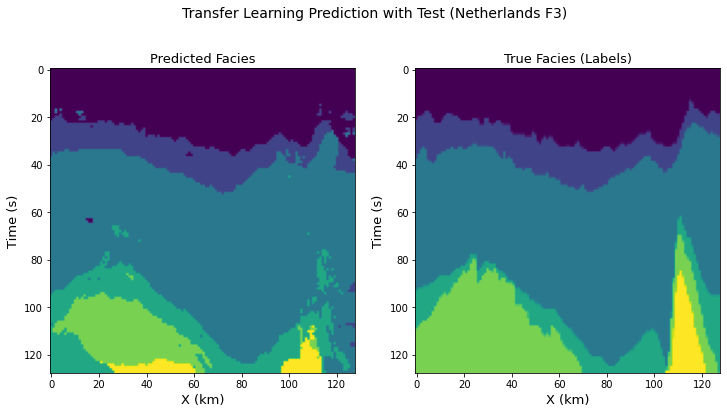

In [123]:
mskip=1
fig, ax = plt.subplots(1,2, figsize=(12,12))
nt=100
k=0 
def AWE_2D_animate(i):
    global k
    #ax1.clear()
    ax[0].imshow(pred_mask_f3_test[k, :, :, 0])
    ax[0].set_xlabel('X (km)', fontsize=13)
    ax[0].set_ylabel('Time (s)', fontsize=13)
    ax[0].set_title('Predicted Facies', fontsize=13)
    ax[1].imshow(y_test_f3[k, :, :])
    ax[1].set_xlabel('X (km)', fontsize=13)
    ax[1].set_ylabel('Time (s)', fontsize=13)
    ax[1].set_title('True Facies (Labels)', fontsize=13)
    fig.suptitle('Transfer Learning Prediction with Test (Netherlands F3)', fontsize=14, y=0.75)
    k += mskip

# . . Call the animator. 
anim6 = animation.FuncAnimation(fig,AWE_2D_animate,frames=20,interval=400)
anim6.save('100examples.mp4', writer = 'ffmpeg', fps = 30)
HTML(anim6.to_html5_video())

In [ ]:
anim6.save('100examples.mp4', writer = 'ffmpeg', fps = 1)

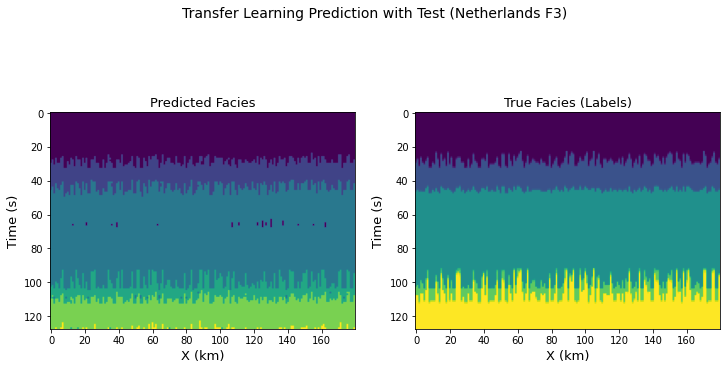

In [ ]:
|fig, ax = plt.subplots(1,2, figsize=(12,12))

ax[0].imshow(tf.keras.backend.transpose(pred_mask_f3_test[:, :, 60, 0]))
ax[0].set_xlabel('X (km)', fontsize=13)
ax[0].set_ylabel('Time (s)', fontsize=13)
ax[0].set_title('Predicted Facies', fontsize=13)
ax[1].imshow(tf.keras.backend.transpose(y_test_f3[:, :, 60]))
ax[1].set_xlabel('X (km)', fontsize=13)
ax[1].set_ylabel('Time (s)', fontsize=13)
ax[1].set_title('True Facies (Labels)', fontsize=13)
fig.suptitle('Transfer Learning Prediction with Test (Netherlands F3)', fontsize=14, y=0.75)
plt.show()